## **Task**

Q1. Suppose you want to invest Rs 100000.00 in the assets of your data set.  
Develop code in Python to prepare an optimal portfolio of the assets corresponding to each of the following Markowitz models. Find  
(a) Optimal portfolio  
(b) Investment strategy(How much to invest in which asset to get minimum risk)  
(c) Total return and variance risk at the optimal point  

Q2. Draw the Markowitz curve and locate the minimum variance point in the turn.

In [1]:
import pandas as pd
import numpy as np

num_assets = 50 # number of assets
capital = 100000 # capital to invest

cov_matrix = pd.read_excel('omf_all_data.xlsx', sheet_name='Covariance Matrix', index_col=0)
# fill the upper triangle of the covariance matrix
covariance_matrix = cov_matrix.fillna(cov_matrix.T)
covariance_matrix = covariance_matrix.values

# matrix of 1s
e = np.array([[1] for _ in range(num_assets)])

# expected rate of return
mu = pd.read_excel('omf_all_data.xlsx', sheet_name='Expected rate of return, E(ri)', index_col=0)
mu = mu.values
mu = mu.T

## **Markowitz Model I**  

**Objective**
Minimize wTΩ w   
subject to  
    eTw=1,  
    short selling is allowed

**Solution**
The optimal portfolio is given by
### $w = \frac{Ω^{-1}  e}{e^T  Ω^{-1}  e}$

In [2]:
# cov^-1 * e / e^T * cov^-1 * e
optimal_portfolio_1 = np.dot(np.linalg.inv(covariance_matrix), e) / np.dot(e.T, np.dot(np.linalg.inv(covariance_matrix), e))

markowitzmodel_1 = pd.DataFrame(optimal_portfolio_1, index=cov_matrix.columns, columns=['Optimal Portfolio 1'])
markowitzmodel_1['Investment Strategy'] = capital * optimal_portfolio_1

markowitzmodel_1.to_excel('markowitzmodel1.xlsx')

# Expected Returns
expected_returns_1 = np.dot(mu.T, capital * optimal_portfolio_1)
print('Expected Returns:', expected_returns_1)

# Variance Risk
variance_risk_1 = np.dot(np.dot(optimal_portfolio_1.T, covariance_matrix), optimal_portfolio_1)
print('Variance Risk:', variance_risk_1)

Expected Returns: [[68.26038373]]
Variance Risk: [[3.24268155e-05]]


## **Markowitz Model II**  

**Objective**
Minimize wTΩ w   
subject to  
    eTw=1,  
    short selling is not allowed

**Solution**  
Solve using the Lagrange multiplier method.

In [3]:
import gurobipy as gp

# Create a new model
model_2 = gp.Model("markowitz2")

# Addition of matrix variable for the stock weights (portfolio)
w = model_2.addMVar(num_assets)

variance_risk = w @ covariance_matrix @ w

# Set objective
model_2.setObjective(variance_risk, gp.GRB.MINIMIZE)

# Constraint: the sum of the weights should be 1
model_2.addConstr(w.sum() == 1, "budget")

# Non-negative weights (short-selling is not allowed)
model_2.addConstr(w >= 0)

# Optimize model
model_2.optimize()

# Get the optimal weights
optimal_portfolio_2 = w.x

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-14
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 51 rows, 50 columns and 100 nonzeros
Model fingerprint: 0xbb10515e
Model has 1275 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-07, 6e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 50 rows and 0 columns
Presolve time: 0.08s
Presolved: 1 rows, 50 columns, 50 nonzeros
Presolved model has 1275 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 49
 AA' NZ     : 1.225e+03
 Factor NZ  : 1.275e+03
 Factor Ops : 4.293e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective

In [4]:
markowitzmodel_2 = pd.DataFrame(optimal_portfolio_2, index=cov_matrix.columns, columns=['Optimal Portfolio 2'])
markowitzmodel_2['Investment Strategy'] = capital * optimal_portfolio_2

markowitzmodel_2.to_excel('markowitzmodel2.xlsx')

# Expected Returns
expected_returns_2 = np.dot(mu.T, capital * optimal_portfolio_2)
print('Expected Returns:', expected_returns_2)

# Variance Risk
variance_risk_2 = np.dot(np.dot(optimal_portfolio_2.T, covariance_matrix), optimal_portfolio_2)
print('Variance Risk:', variance_risk_2)

Expected Returns: [80.76229064]
Variance Risk: 3.921775520705508e-05


## **Markowitz Model III**  

**Objective**
Minimize wTΩ w   
subject to  
    eTw=1,  
    total return is exactly 5%,  
    short selling is allowed

**Solution**  
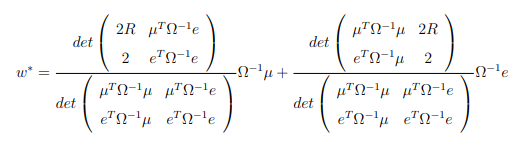

In [5]:
R = 0.05

muTsigmainverseE = np.dot(np.dot(mu.T, np.linalg.inv(covariance_matrix)), e)[0]
eTsigmainverseE = np.dot(np.dot(e.T, np.linalg.inv(covariance_matrix)), e)
muTsigmainverseMu = np.dot(np.dot(mu.T, np.linalg.inv(covariance_matrix)), mu)[0]
eTsigmainverseMu = np.dot(np.dot(e.T, np.linalg.inv(covariance_matrix)), mu)[0]

# v1 = det([[2R, muTsigmainverseE],[2, eTsigmainverseE]]) / det([[muTsigmainverseE, muTsigmainverseE],[eTsigmainverseMu, eTsigmainverseE]])
# v2 = det([[muTsigmainverseMu, 2R],[eTsigmainverseMu, 2]]) / det([[muTsigmainverseMu, muTsigmainverseE],[eTsigmainverseMu, eTsigmainverseE]])

v1 = (2*R*eTsigmainverseE - 2*muTsigmainverseE) / (muTsigmainverseMu*eTsigmainverseE - muTsigmainverseE*eTsigmainverseMu)
#v1 = np.linalg.det([[2*R, muTsigmainverseE],[2, eTsigmainverseE]]) / np.linalg.det([[muTsigmainverseE, muTsigmainverseE],[eTsigmainverseMu, eTsigmainverseE]])
v2 = (muTsigmainverseMu*2 - 2*R*eTsigmainverseMu) / (muTsigmainverseMu*eTsigmainverseE - muTsigmainverseE*eTsigmainverseMu)

optimal_portfolio_3 = (v1[0] * np.dot(np.linalg.inv(covariance_matrix), mu) + v2[0] * np.dot(np.linalg.inv(covariance_matrix), e))/2

In [6]:
markowitzmodel_3 = pd.DataFrame(optimal_portfolio_3, index=cov_matrix.columns, columns=['Optimal Portfolio 3'])
markowitzmodel_3['Investment Strategy'] = capital * optimal_portfolio_3

markowitzmodel_3.to_excel('markowitzmodel3.xlsx')

# Expected Returns
expected_returns_3 = np.dot(mu.T, capital * optimal_portfolio_3)
print('Expected Returns:', expected_returns_3)

# Variance Risk
variance_risk_3 = np.dot(np.dot(optimal_portfolio_3.T, covariance_matrix), optimal_portfolio_3)
print('Variance Risk:', variance_risk_3)

Expected Returns: [[5000.]]
Variance Risk: [[0.01918344]]


## **Markowitz Model IV**  

**Objective**
Minimize wTΩ w   
subject to  
    eTw=1,  
    total return is a minimum of 5%,  
    short selling is allowed

**Solution**  
Solve using the Lagrange multiplier method.

In [7]:
import gurobipy as gp

# Create a new model
model_4 = gp.Model("markowitz4")

# Addition of matrix variable for the stock weights (portfolio)
w = model_4.addMVar(num_assets)

variance_risk = w @ covariance_matrix @ w

# Set objective
model_4.setObjective(variance_risk, gp.GRB.MINIMIZE)

# Constraint: the sum of the weights should be 1
model_4.addConstr(w.sum() == 1, "budget")

# Total return constraint
model_4.addConstr(mu.T @ w >= 0.005, "return")

# Non-negative weights (short-selling is not allowed)
# model2.addConstr(w >= 0)

# Optimize model
model_4.optimize()

# Get the optimal weights
optimal_portfolio_4 = w.x

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 50 columns and 100 nonzeros
Model fingerprint: 0xc9830163
Model has 1275 quadratic objective terms
Coefficient statistics:
  Matrix range     [8e-05, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-07, 6e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-03, 1e+00]
Presolve time: 0.01s
Presolved: 2 rows, 50 columns, 100 nonzeros
Presolved model has 1275 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 49
 AA' NZ     : 1.275e+03
 Factor NZ  : 1.326e+03
 Factor Ops : 4.553e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.14643589e+05 -2.146435

In [8]:
markowitzmodel_4 = pd.DataFrame(optimal_portfolio_4, index=cov_matrix.columns, columns=['Optimal Portfolio 4'])
markowitzmodel_4['Investment Strategy'] = capital * optimal_portfolio_4

markowitzmodel_4.to_excel('markowitzmodel4.xlsx')

# Expected Returns
expected_returns_4 = np.dot(mu.T, capital * optimal_portfolio_4)
print('Expected Returns:', expected_returns_4)

# Variance Risk
variance_risk_4 = np.dot(np.dot(optimal_portfolio_4.T, covariance_matrix), optimal_portfolio_4)
print('Variance Risk:', variance_risk_4)

Expected Returns: [500.00000004]
Variance Risk: 0.0004376089574916398


## **Markowitz Curve and MVP**  
Minimum variance point is the point on the Markowitz curve where the variance is minimum.

In [9]:
# vary R from 0 to 0.1
returns = []
risks = []

for R in np.arange(-0.01, 0.1, 0.0001):
    muTsigmainverseE = np.dot(np.dot(mu.T, np.linalg.inv(covariance_matrix)), e)[0]
    eTsigmainverseE = np.dot(np.dot(e.T, np.linalg.inv(covariance_matrix)), e)
    muTsigmainverseMu = np.dot(np.dot(mu.T, np.linalg.inv(covariance_matrix)), mu)[0]
    eTsigmainverseMu = np.dot(np.dot(e.T, np.linalg.inv(covariance_matrix)), mu)[0]

    # v1 = det([[2R, muTsigmainverseE],[2, eTsigmainverseE]]) / det([[muTsigmainverseE, muTsigmainverseE],[eTsigmainverseMu, eTsigmainverseE]])
    # v2 = det([[muTsigmainverseMu, 2R],[eTsigmainverseMu, 2]]) / det([[muTsigmainverseMu, muTsigmainverseE],[eTsigmainverseMu, eTsigmainverseE]])

    v1 = (2*R*eTsigmainverseE - 2*muTsigmainverseE) / (muTsigmainverseMu*eTsigmainverseE - muTsigmainverseE*eTsigmainverseMu)
    #v1 = np.linalg.det([[2*R, muTsigmainverseE],[2, eTsigmainverseE]]) / np.linalg.det([[muTsigmainverseE, muTsigmainverseE],[eTsigmainverseMu, eTsigmainverseE]])
    v2 = (muTsigmainverseMu*2 - 2*R*eTsigmainverseMu) / (muTsigmainverseMu*eTsigmainverseE - muTsigmainverseE*eTsigmainverseMu)

    optimal_portfolio_3 = (v1[0] * np.dot(np.linalg.inv(covariance_matrix), mu) + v2[0] * np.dot(np.linalg.inv(covariance_matrix), e))/2

    # Expected Returns
    returns.append(np.dot(mu.T, optimal_portfolio_3)[0][0])
    # print('Expected Returns:', expected_returns_3)

    # Variance Risk
    risks.append(np.dot(np.dot(optimal_portfolio_3.T, covariance_matrix), optimal_portfolio_3)[0][0])
    # print('Variance Risk:', variance_risk_3)

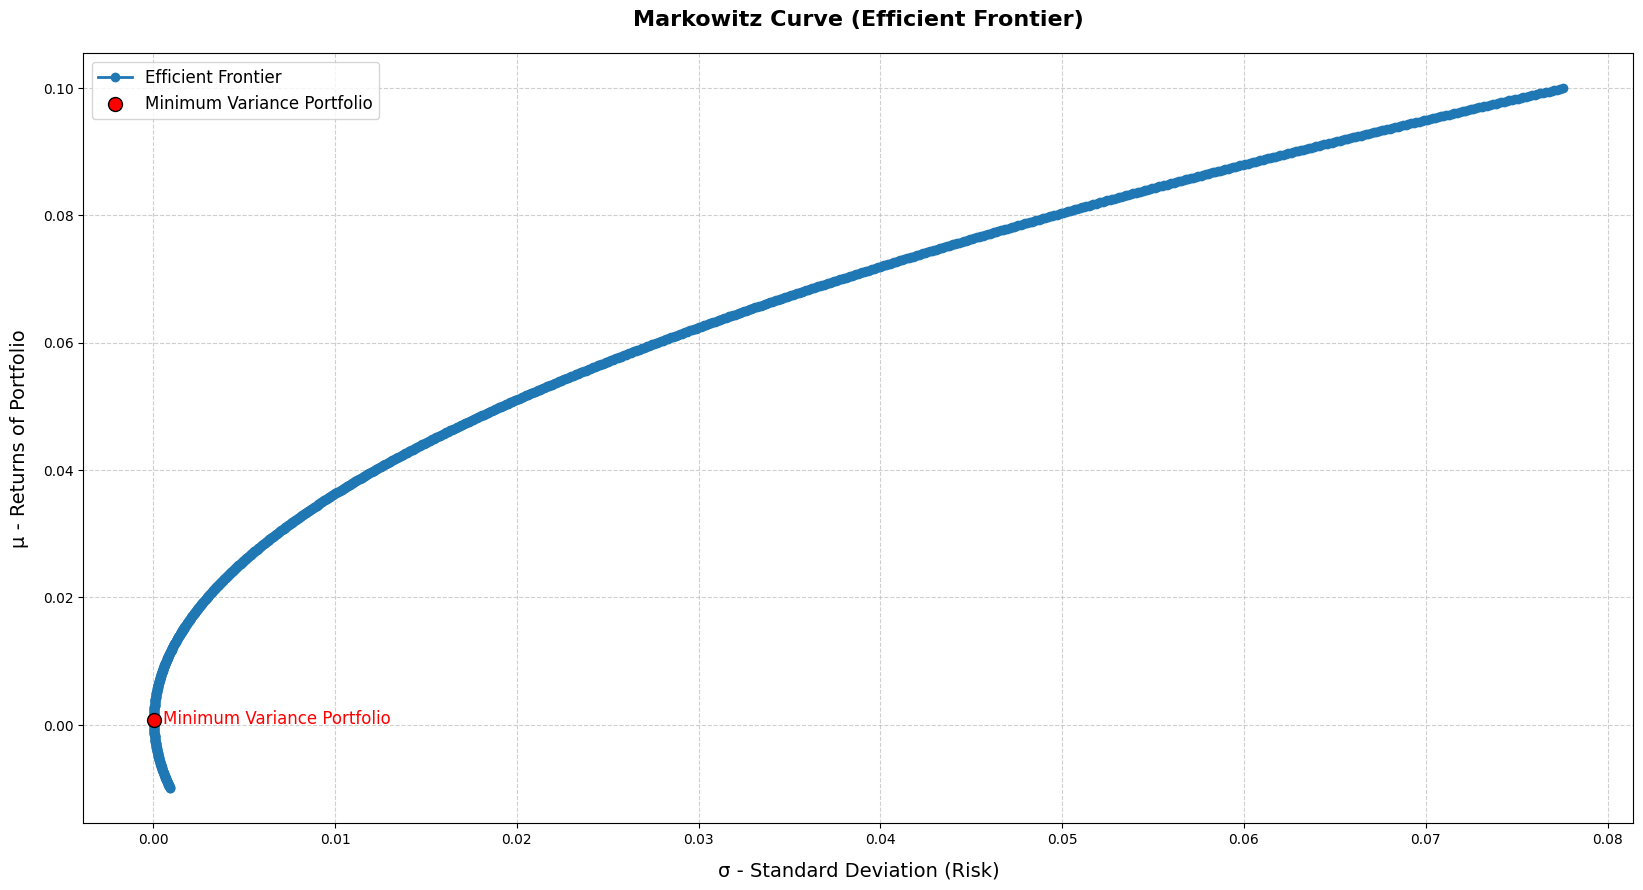

Minimum Variance Portfolio: 3.242919831192359e-05 0.0006999999999999353


<Figure size 640x480 with 0 Axes>

In [10]:
# Plot the Markowitz Curve (Efficient Frontier)
import matplotlib.pyplot as plt

# Plot risks and returns
plt.figure(figsize=(20, 10))
plt.plot(risks, returns, marker='o', linestyle='-', color='#1f77b4', linewidth=2, markersize=6, label='Efficient Frontier')

# Mark the minimum variance portfolio
min_risk = min(risks)
min_risk_idx = risks.index(min_risk)
plt.scatter(min_risk, returns[min_risk_idx], color='red', s=100, edgecolor='black', zorder=5, label='Minimum Variance Portfolio')
plt.text(min_risk + 0.0005, returns[min_risk_idx] - 0.0005, 'Minimum Variance Portfolio', fontsize=12, ha='left', color='red')

# Add labels and title with improved font settings
plt.xlabel('σ - Standard Deviation (Risk)', fontsize=14, labelpad=10)
plt.ylabel('μ - Returns of Portfolio', fontsize=14, labelpad=10)
plt.title('Markowitz Curve (Efficient Frontier)', fontsize=16, fontweight='bold', pad=20)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='best', fontsize=12)

# Show plot
plt.show();

# Output the minimum variance portfolio
print('Minimum Variance Portfolio:', min_risk, returns[min_risk_idx])
plt.savefig('output/markowitz_curve.png')